# Development notebook for optimization of HS mixtures

---
## Datastructure for HS optimization variables

Q = number of types

N = number of particles

File to store in json format and read into a dictionary:

{

    'type_to_diameter': [d1, d2, ..., dQ],
    
    'particle_to_type': [t1, t2, ..., tN]
    
 }
 
 ---

---

## XYZ reader

Returns a ''trajectory'' datastructure:

{

    'N': number,
    
    'M': number,

    'box': (Lx, Ly, Lz),
    
    'ids': [id_1, id_2, ..., id_3],
    
    'frames': [frame_1, frame_2, ..., frame_M],

}

where each frame is an order preserved (to maintain identities) list of coordinates:

[
[x1, y1, z1], 
[x2, y2, z2], 
..., 
[xN, yN, zN]
]

In [1]:
from numpy import array, std, mean, all, floor
import re

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
def ReadXYZ(filename):
    #regex used to parse the data
    xyz_regex = r'(?:([a-zA-Z]+)\s+([0-9\.e\-\+]+)\s+([0-9\.e\-\+]+)\s+([0-9\.e\-\+]+)\s+(?:[0-9\.e\-\+]+))'
    L_regex = r'(?:(?:L\s*=\s*([0-9\.e\-\+]+))|(?:Lx\s*=\s*([0-9\.e\-\+]+)\s+Ly\s*=\s*([0-9\.e\-\+]+)\s+Lz\s*=\s*([0-9\.e\-\+]+)))'
    
    #read in the data
    with open(filename, "r") as ins:
        frames = [] 
        Ns = []
        Lxs = []
        Lys = []
        Lzs = []
        ids_all = []
        
        ids = []
        coords, coords_count = [], 0
        for line in ins:
            search = re.search(xyz_regex, line)
            if search:
                coords.append(array([float(search.group(2)), float(search.group(3)), float(search.group(4))]))
                ids.append(search.group(1))
                coords_count = coords_count + 1
            elif coords:
                coords = array(coords)
                ids = array(ids)
                sorter = ids.argsort()
                coords = coords[sorter]
                ids = ids[sorter]
                frames.append(array(coords))
                Ns.append(coords_count)
                ids_all.append(ids)
                coords, coords_count = [], 0
                ids = []
                search_L = re.search(L_regex, line)
                if search_L:
                    if search_L.group(1):
                        Lx, Ly, Lz = float(search_L.group(1)), float(search_L.group(1)), float(search_L.group(1))
                    else:
                        Lx, Ly, Lz = float(search_L.group(2)), float(search_L.group(3)), float(search_L.group(4))
                    Lxs.append(Lx), Lys.append(Ly), Lzs.append(Lz)
            else:
                search_L = re.search(L_regex, line)
                if search_L:
                    if search_L.group(1):
                        Lx, Ly, Lz = float(search_L.group(1)), float(search_L.group(1)), float(search_L.group(1))
                    else:
                        Lx, Ly, Lz = float(search_L.group(2)), float(search_L.group(3)), float(search_L.group(4))
                    Lxs.append(Lx), Lys.append(Ly), Lzs.append(Lz)
                    
        #append final frame
        coords = array(coords)
        ids = array(ids)
        sorter = ids.argsort()
        coords = coords[sorter]
        ids = ids[sorter]
        frames.append(array(coords))     
        Ns.append(coords_count)
        ids_all.append(ids)
        
    #check that all frames yielded the same number of particles
    if len(set(Ns)) != 1:
        raise Exception('Inconsistent number of particles!')
    
    #check for coherent sorting
    if not all(ids_all[0] == ids_all):
        raise Exception('Inconsistent particle ids!')
    
    #check that all box lengths are the same
    if std(Lxs)/mean(Lxs) >= 0.000001:
        raise Exception('Inconsistent box lengths!')
    if std(Lys)/mean(Lys) >= 0.000001:
        raise Exception('Inconsistent box lengths!')
    if std(Lzs)/(mean(Lzs) + 0.000001) >= 0.000001:
        raise Exception('Inconsistent box lengths!')
        
    # (*it).rx = (*it).rx - floor((*it).rx / state.L)*state.L;
    
    #set box lengths
    Lx, Ly, Lz = Lxs[0], Lys[0], Lzs[0]
    box = array([Lx, Ly, Lz])
    
    #enforce periodic wrapping in case of rounding errors in the xyz file
    frames = array(frames)
    frames = frames - floor(frames / box)*box
    
    return {'N': Ns[0], 'M': len(frames), 'box': box, 'ids': ids_all[0], 'frames': frames}

In [3]:
trajectory = ReadXYZ('./data/trajectory.xyz')

In [4]:
trajectory['box']

array([ 8.15688,  8.15688,  8.15688])

In [5]:
trajectory['frames'][0][0:12]

array([[ 1.64506 ,  1.10321 ,  3.35333 ],
       [ 0.573582,  1.11671 ,  4.36161 ],
       [ 5.46364 ,  5.39178 ,  2.55042 ],
       [ 2.17166 ,  1.46468 ,  2.40824 ],
       [ 3.01938 ,  3.89474 ,  6.57988 ],
       [ 5.346   ,  3.85425 ,  3.87463 ],
       [ 3.40079 ,  0.750973,  1.26841 ],
       [ 1.77816 ,  3.6732  ,  4.92433 ],
       [ 4.41075 ,  5.56014 ,  2.67419 ],
       [ 2.87205 ,  6.58255 ,  4.03447 ],
       [ 2.67679 ,  7.79504 ,  6.84266 ],
       [ 2.14251 ,  0.633316,  6.37852 ]])

---

---

## Build cell lists for frames datastructure to expedite overlap checking

returns a modified trajectory entity ala:

{

    'N': number,
    
    'M': number,

    'box': (Lx, Ly, Lz),
    
    'ids': [id_1, id_2, ..., id_3],
    
    'frames': [frame_1, frame_2, ..., frame_M],
    
    'cell_nums': (ncx, ncy, ncz),
    
    'cell_size' (Lcx, Lcy, Lcz),
    
    'cell_lists' [cell_list_1, cell_list_2, ..., cell_list_M]

}


In [4]:
from numba import jit
from numpy import empty, maximum, minimum
from copy import deepcopy

In [5]:
def MakeCellLists(state, trajectory):
    
    #augmented trajectory
    trajectory['cell_lists'] = []
    
    #identify the number of cells in each direction with a minimum of 1
    dmax = max(state['type_to_diameter'])
    cell_nums = trajectory['box'] / dmax
    cell_nums = maximum(1, cell_nums.astype(int))
    cell_size = trajectory['box'] / cell_nums.astype(float)
    
    #loop over the frames and make a cell list (must be done manually to ensure lists are preserved)
    cell_list = empty(cell_nums, dtype=object)
    for cellx in range(cell_nums[0]):
        for celly in range(cell_nums[1]):
            for cellz in range(cell_nums[2]):
                cell_list[cellx, celly, cellz] = []
    
    #add the number of cells
    trajectory['cell_nums'] = cell_nums
    trajectory['cell_size'] = cell_size
    
    #build the cell list
    for frame in trajectory['frames']:
        cells = frame / cell_size
        cells = cells.astype(int)
        cell_list_frame = deepcopy(cell_list)
        for i in range(trajectory['N']):
            cellx, celly, cellz = cells[i][0], cells[i][1], cells[i][2]
            cell_list_frame[cellx, celly, cellz].append(i) 
            trajectory['cell_lists'].append(cell_list_frame)

    return None

In [6]:
state = {'type_to_diameter': [1.5]}
MakeCellLists(state, trajectory)

In [15]:
trajectory['M']

10000

In [16]:
trajectory['cell_lists'][0]

array([[[list([119, 205]), list([101, 270, 281]), list([1, 62, 273]),
         list([296]), list([54, 289])],
        [list([188]), list([97, 156]), list([31, 32, 43, 169]),
         list([211, 279]), list([144, 165, 288])],
        [list([120, 191, 264]), list([234]), list([290]), list([99, 239]),
         list([147, 251, 274])],
        [list([190, 247]), list([122]), list([111, 298]),
         list([26, 58, 196]), list([149, 153])],
        [list([253]), list([181, 183, 184]), list([82, 198]),
         list([21, 229]), list([17, 94, 129])]],

       [[list([295]), list([3, 55, 64, 182]), list([0, 212]),
         list([11, 60, 168]), list([76, 90])],
        [list([48, 236, 259]), list([63, 258, 282]), list([45, 155, 201]),
         list([49, 241]), list([124, 179])],
        [list([77, 121]), list([158]), list([53, 116, 206]),
         list([7, 100, 209]), list([4, 133, 172, 185, 240])],
        [list([41, 237]), list([34, 160, 189, 192, 242]), list([50, 127]),
         list([66, 10

## Calculate maximum particle diameters allowed for each particle across all frames

In [21]:
from numpy import minimum, rint, sqrt, power, zeros

In [22]:
#@jit(nopython=True)
def MaximumDiameters(state, trajectory):
    #explicitly get a few variables for succinct representation
    box, N, M = trajectory['box'], trajectory['N'], trajectory['M']
    cell_nums = trajectory['cell_nums'].astype(int)
    cell_size = trajectory['cell_size']
    particle_to_type = state['particle_to_type']
    type_to_diameter = state['type_to_diameter']
    L_min = min(box)
    
    #initialize the matrix of values
    diameter_stats = zeros((N, M))
    
    #loop over the frames and use the cell lists to calculate the maximum diameter allowed
    for m in range(M):
        if m % 100 == 0:
            print m
        
        #get the relevant frame and loop over particles
        frame = trajectory['frames'][m]
        cell_list = trajectory['cell_lists'][m]
        for n in range(N):
            
            #single particle coordinate and corresponding cell
            coord = frame[n]
            diameter = type_to_diameter[particle_to_type[n]]
            cell = coord / cell_size
            cell = cell.astype(int)
            
            #loop over neighbor cells with periodic conditions but only if it makes sense (4 or more cells)
            diameter_max = L_min
            ncx_max, ncy_max, ncz_max = minimum(2, cell_nums-1)
            for i in range(-1, ncx_max):
                for j in range(-1, ncy_max):
                    for k in range(-1, ncz_max):
                        neighbor_cell = cell + array([i, j, k]).astype(int)
                        neighbor_cell = neighbor_cell - (neighbor_cell/cell_nums)*cell_nums
                        ncx, ncy, ncz = neighbor_cell
                        #loop over the particles in that cell and find the maximum allowed diameter for that particle
                        for nn in cell_list[ncx][ncy][ncz]:
                            neighbor_coord = frame[nn]
                            neighbor_diameter = type_to_diameter[particle_to_type[nn]]
                            #peridically wrapped distance
                            R = coord - neighbor_coord
                            R = R - rint(R/box)*box
                            R = sqrt(sum(power(R, 2.0)))
                            diameter_max_test = (n != nn)*(2.0*R - neighbor_diameter) + (n == nn)*L_min
                            diameter_max = min(diameter_max, diameter_max_test)
                            
            #insert the maximum allowed diameter so as to not generate an overlap                
            diameter_stats[n][m] = diameter_max
                        
    return diameter_stats

In [7]:
state = {'particle_to_type': array(range(300)).astype(int),
         'type_to_diameter': array([1.0 for i in range(300)])}

In [8]:
trajectory['M'] = 3000
trajectory['frames'] = trajectory['frames'][:3000]
trajectory['cell_lists'] = trajectory['cell_lists'][:3000]

In [26]:
maximum_diameters = MaximumDiameters(state, trajectory)

0
100
200


In [27]:
maximum_diameters[299]

array([ 1.80986978,  1.96321608,  2.17805047,  1.7661054 ,  2.11697223,
        1.77074393,  1.91726352,  1.83027128,  1.88943402,  1.89922579,
        1.82760532,  1.94826612,  2.01222435,  1.94294183,  1.96603258,
        1.77240323,  1.77424713,  1.79194092,  1.89135475,  2.01957122,
        2.02688651,  1.81598658,  2.14733656,  1.78887779,  1.83574901,
        2.36695224,  1.80902892,  1.98626177,  2.30388098,  2.38414732,
        2.00360181,  2.16048922,  2.21009744,  2.11315208,  2.09196673,
        1.99632944,  2.59204499,  1.88378984,  1.91134302,  1.81826622,
        2.04972648,  2.10928882,  1.83393355,  1.97300508,  2.10341462,
        2.11265666,  1.80042579,  1.91465733,  1.89525894,  1.89722268,
        1.90397965,  1.82371487,  2.00378267,  2.13963466,  2.2444758 ,
        3.61207494,  1.98805724,  2.06821033,  2.00985409,  2.12795206,
        1.75562167,  2.16486913,  1.93215001,  2.23482732,  1.89938798,
        2.46745352,  1.95509584,  1.95094165,  1.83812837,  1.85

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

(array([ 151.,   80.,   39.,   21.,    1.,    1.,    2.,    0.,    2.,    3.]),
 array([ 1.74386208,  1.9435102 ,  2.14315831,  2.34280642,  2.54245453,
         2.74210264,  2.94175075,  3.14139886,  3.34104698,  3.54069509,
         3.7403432 ]),
 <a list of 10 Patch objects>)

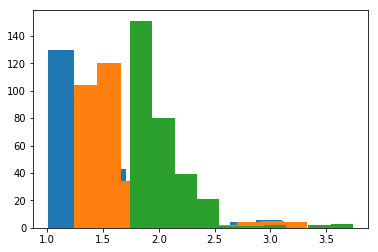

In [29]:
plt.hist(maximum_diameters[0])
plt.hist(maximum_diameters[150])
plt.hist(maximum_diameters[299])

In [438]:
x = array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
index = array([2,2])
x[index]

array([[ 9, 10, 11, 12],
       [ 9, 10, 11, 12]])

In [420]:
cell = array([0,1,-1])
cell_nums = array([1, 1, 1])
ncx_max, ncy_max, ncz_max = minimum(2, cell_nums-1)
print ncx_max
for i in range(-1, ncx_max):
    for j in range(-1, ncy_max):
        for k in range(-1, ncz_max):
            neighbor_cell = cell + array([i, j, k]).astype(int)
            neighbor_cell = neighbor_cell - (neighbor_cell/cell_nums)*cell_nums
            print neighbor_cell

0
[0 0 0]


In [402]:
0.7-0.645

0.05499999999999994

In [404]:
0.4+0.055

0.455

In [385]:
from numpy import  minimum

In [386]:
minimum(array([2,4,5]), 2)

array([2, 2, 2])

In [391]:
cell_nums = array([1,3,2])
minimum(2, cell_nums-1)

array([0, 2, 1])

In [ ]:
rij-(di+dj)/2=0

In [360]:
array([1,2,3]).astype(int)

array([1, 2, 3])

In [318]:
nc = 5   #(0,1,2,3,4)

In [330]:
x=9
print x/4
print x%4

2
1


In [343]:
x=5
x - (x/5)*5

0

In [350]:
A = len((0,1,2,3,4,5))

In [358]:
x=-7
x - (x/A)*A

5

In [376]:
cell_nums = array([4,6,2])
neighbor_cell = array([-7,7,9])
neighbor_cell - (neighbor_cell/cell_nums)*cell_nums

array([1, 1, 1])

In [ ]:
[x, y, z] / [Lx, Ly, Lz]

In [112]:
ncx=3
ncy=4
ncz=5
cell_nums = array([ncx, ncy, ncz])
cell_list = empty(cell_nums, dtype=object)
for cellx in range(cell_nums[0]):
    for celly in range(cell_nums[1]):
        for cellz in range(cell_nums[2]):
            cell_list[cellx, celly, cellz] = []

In [113]:
cell_list[1,3,1].append(23)

In [114]:
cell_list

array([[[[], [], [], [], []],
        [[], [], [], [], []],
        [[], [], [], [], []],
        [[], [], [], [], []]],

       [[[], [], [], [], []],
        [[], [], [], [], []],
        [[], [], [], [], []],
        [[], [23], [], [], []]],

       [[[], [], [], [], []],
        [[], [], [], [], []],
        [[], [], [], [], []],
        [[], [], [], [], []]]], dtype=object)

In [72]:
full((2,3,4), )

ValueError: could not broadcast input array from shape (0) into shape (2,3,4)

In [32]:
a = array([1,2,3,4,5])

In [33]:
b = array([[1,2,3,4,5], [1,2,3,4,5], [1,5,3,4,5]])

In [43]:
all(a == b)

False

In [36]:
a == b

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True, False,  True,  True,  True]], dtype=bool)

In [201]:
frames = array([[[1,2,3], [3,4,5], [5,6,7]], [[1,2,3], [3,4,5], [5,6,7]]])
box = array([1.,2.,3.])
frames / box

array([[[ 1.        ,  1.        ,  1.        ],
        [ 3.        ,  2.        ,  1.66666667],
        [ 5.        ,  3.        ,  2.33333333]],

       [[ 1.        ,  1.        ,  1.        ],
        [ 3.        ,  2.        ,  1.66666667],
        [ 5.        ,  3.        ,  2.33333333]]])

In [490]:
from libc.math cimport sin

SyntaxError: invalid syntax (<ipython-input-490-3cbc0f1bdfd3>, line 1)

In [492]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [493]:
%%cython

cdef int a = 0
for i in range(10):
    a += i
print(a)

DistutilsPlatformError: Unable to find vcvarsall.bat

In [31]:
%load_ext Cython

In [3]:
try:
    from setuptools import setup
    from setuptools import Extension
except ImportError:
    from distutils.core import setup
    from distutils.extension import Extension

In [6]:
%%cython

# distutils: language = c++
# cython: boundscheck = False

# Import the map and vector templates from the STL
from libcpp.map cimport map as cpp_map
from libcpp.vector cimport vector as cpp_vector
from libcpp.utility cimport pair as cpp_pair

ctypedef cpp_vector[int] cpp_neighbourhood
ctypedef cpp_map[int, cpp_neighbourhood] cpp_adjacency_map
ctypedef cpp_pair[int, cpp_neighbourhood] cpp_item

# Import a few operators because they aren't supported by cython syntax
from cython.operator cimport dereference as deref
from cython.operator cimport preincrement as preinc


In [ ]:
from numpy import 

In [55]:
%%cython

# distutils: language = c++
# cython: boundscheck = False

from libcpp.vector cimport vector
from libc.math cimport round, sqrt
from numpy import zeros

def MaximumDiameters(state, trajectory):
    #use c++ datatypes as needed
    cdef int N, M
    cdef float L_x, L_y, L_z
    cdef int cn_x, cn_y, cn_z
    cdef float cs_x, cs_y, cs_z
    cdef vector[int] particle_to_type
    cdef vector[float] type_to_diameter
    cdef float L_min
    cdef vector[vector[float]] diameter_stats
    cdef vector[vector[vector[float]]] frames
    cdef vector[vector[vector[vector[vector[int]]]]] cell_lists
    
    #assign variables
    N = trajectory['N']
    M = trajectory['M']
    L_x = trajectory['box'][0]
    L_y = trajectory['box'][1]
    L_z = trajectory['box'][2]
    cn_x = trajectory['cell_nums'][0]
    cn_y = trajectory['cell_nums'][1]
    cn_z = trajectory['cell_nums'][2]
    cs_x = trajectory['cell_size'][0]
    cs_y = trajectory['cell_size'][1]
    cs_z = trajectory['cell_size'][2]    
    particle_to_type = state['particle_to_type']
    type_to_diameter = state['type_to_diameter']
    L_min = min([L_x, L_y, L_z])
    diameter_stats = zeros((N, M))
    frames = trajectory['frames']
    cell_lists = trajectory['cell_lists']
    
    #needed in the loop
    cdef int c_x, c_y, c_z
    cdef vector[vector[float]] frame
    cdef vector[vector[vector[vector[int]]]] cell_list
    cdef float r_x, r_y, r_z
    cdef float diameter
    
    #loop over the frames and use the cell lists to calculate the maximum diameter allowed
    cdef int m
    cdef int n
    for m in range(M):
        if m % 100 == 0:
            print m
        
        #get the relevant frame and loop over particles
        frame = frames[m]
        cell_list = cell_lists[m]
        for n in range(N):
            
            #single particle coordinate and corresponding cell
            #coord = frame[n]
            #diameter = type_to_diameter[particle_to_type[n]]
            #cell = coord / cell_size
            #cell = cell.astype(int)
            
            #extract the coords and cell indicies
            r_x = frame[n][0]
            r_y = frame[n][0]
            r_z = frame[n][0]
            diameter = type_to_diameter[particle_to_type[n]]
            c_x = int(r_x / L_x)
            c_y = int(r_y / L_y)
            c_z = int(r_z / L_z)
            
                        
    return diameter_stats

In [52]:
MaximumDiameters(state, trajectory)

0


[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

In [20]:
trjectory

NameError: name 'trjectory' is not defined

In [10]:
%load_ext Cython

In [20]:
%%cython

# distutils: language = c++
# cython: boundscheck = False

from libcpp.vector cimport vector
from libc.math cimport round, sqrt, fmin
from numpy import zeros, array

def MaximumDiameters(state, trajectory):
    #use c++ datatypes as needed
    cdef int N, M
    cdef double L_x, L_y, L_z
    cdef int cnums_x, cnums_y, cnums_z
    cdef double csize_x, csize_y, csize_z
    cdef vector[int] particle_to_type
    cdef vector[double] type_to_diameter
    cdef double L_min
    cdef vector[vector[double]] diameter_stats
    cdef vector[vector[vector[double]]] frames
    cdef vector[vector[vector[vector[vector[int]]]]] cell_lists
    
    #assign variables
    N = trajectory['N']
    M = trajectory['M']
    L_x = trajectory['box'][0]
    L_y = trajectory['box'][1]
    L_z = trajectory['box'][2]
    cnums_x = trajectory['cell_nums'][0]
    cnums_y = trajectory['cell_nums'][1]
    cnums_z = trajectory['cell_nums'][2]
    csize_x = trajectory['cell_size'][0]
    csize_y = trajectory['cell_size'][1]
    csize_z = trajectory['cell_size'][2]    
    particle_to_type = state['particle_to_type']
    type_to_diameter = state['type_to_diameter']
    L_min = min([L_x, L_y, L_z])
    diameter_stats = zeros((N, M))
    frames = trajectory['frames']
    cell_lists = trajectory['cell_lists']
    
    #free up some memory
    trajectory = None
    
    #needed in the loop
    cdef int c_x, c_y, c_z, cn_x, cn_y, cn_z
    cdef vector[vector[double]] frame
    cdef vector[vector[vector[vector[int]]]] cell_list
    cdef double r_x, r_y, r_z, rn_x, rn_y, rn_z
    cdef double diameter, diameter_max, diameter_max_test
    cdef double Rx, Ry, Rz, R
    
    #loop over the frames and use the cell lists to calculate the maximum diameter allowed
    cdef int m, n, nn, dc_x, dc_y, dc_z
    for m in range(M):        
        #get the relevant frame and cell list and loop over particles
        frame = frames[m]
        cell_list = cell_lists[m]
        
        #loop over the particles in a frame
        for n in range(N):
            #extract the coords and cell indicies
            r_x = frame[n][0]
            r_y = frame[n][1]
            r_z = frame[n][2]
            diameter = type_to_diameter[particle_to_type[n]]
            c_x = int(r_x / L_x)
            c_y = int(r_y / L_y)
            c_z = int(r_z / L_z)
            
            #loop over neighbor cells with periodic conditions but only if it makes sense (4 or more cells)
            diameter_max = L_min
            dc_x_max = min(2, cnums_x)
            dc_y_max = min(2, cnums_y)
            dc_z_max = min(2, cnums_z)
            for dc_x in range(-1, dc_x_max):
                for dc_y in range(-1, dc_y_max):
                    for dc_z in range(-1, dc_z_max):
                        cn_x = c_x + dc_x
                        cn_y = c_y + dc_y
                        cn_z = c_z + dc_z
                        cn_x = cn_x - (cn_x/cnums_x)*cnums_x
                        cn_y = cn_y - (cn_y/cnums_y)*cnums_y
                        cn_z = cn_z - (cn_z/cnums_z)*cnums_z
                        
                        #loop over the particles in that cell and find the maximum allowed diameter for that particle
                        for nn in cell_list[cn_x][cn_y][cn_z]:
                            rn_x = frame[nn][0]
                            rn_y = frame[nn][1]
                            rn_z = frame[nn][2]
                            neighbor_diameter = type_to_diameter[particle_to_type[nn]]
                            
                            #peridically wrapped distance
                            R_x = r_x - rn_x
                            R_y = r_y - rn_y
                            R_z = r_z - rn_z
                            R_x = R_x - round(R_x/L_x)*L_x
                            R_y = R_y - round(R_y/L_y)*L_y
                            R_z = R_z - round(R_z/L_z)*L_z
                            R = sqrt(R_x*R_x + R_y*R_y + R_z*R_z)
                            
                            #compute the maximum diameter
                            diameter_max_test = float(n != nn)*(2.0*R - neighbor_diameter) + float(n == nn)*L_min
                            diameter_max = fmin(diameter_max, diameter_max_test)
                            
            #insert the maximum allowed diameter so as to not generate an overlap                
            diameter_stats[n][m] = diameter_max
    
    #return a pythonized array for analysis
    return array(diameter_stats)

In [21]:
maximum_diameters = MaximumDiameters(state, trajectory)

In [22]:
maximum_diameters[123]

array([ 3.46542557,  2.14140605,  1.51688584, ...,  1.45188406,
        1.3090774 ,  1.8634276 ])

(array([ 263.,  406.,  416.,  355.,  265.,  374.,  306.,  183.,   88.,
          71.,   65.,   68.,   44.,   22.,   12.,   11.,    4.,    3.,
           1.,    3.,    3.,    1.,    1.,    2.,    1.,    4.,    3.,
           4.,    2.,    1.,    4.,    3.,    2.,    1.,    4.,    1.,
           2.,    0.,    0.,    1.]),
 array([ 1.74019222,  1.79849597,  1.85679973,  1.91510348,  1.97340724,
         2.031711  ,  2.09001475,  2.14831851,  2.20662226,  2.26492602,
         2.32322978,  2.38153353,  2.43983729,  2.49814104,  2.5564448 ,
         2.61474856,  2.67305231,  2.73135607,  2.78965982,  2.84796358,
         2.90626734,  2.96457109,  3.02287485,  3.0811786 ,  3.13948236,
         3.19778612,  3.25608987,  3.31439363,  3.37269738,  3.43100114,
         3.4893049 ,  3.54760865,  3.60591241,  3.66421616,  3.72251992,
         3.78082368,  3.83912743,  3.89743119,  3.95573494,  4.0140387 ,
         4.07234246]),
 <a list of 40 Patch objects>)

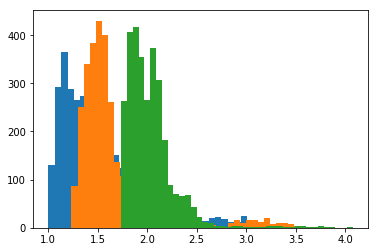

In [23]:
plt.hist(maximum_diameters[0], bins=40)
plt.hist(maximum_diameters[150], bins=40)
plt.hist(maximum_diameters[299], bins=40)

In [24]:
from numpy import median

In [30]:
medians = median(maximum_diameters, axis=1)

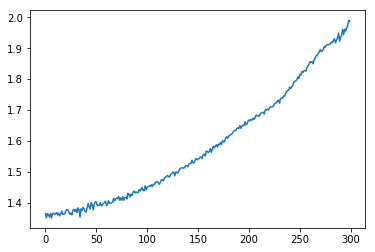

In [31]:
plt.plot(medians)

In [ ]:
hello